<a href="https://colab.research.google.com/github/Dima200206/-2/blob/main/%D0%9B%D0%917_%D0%9A%D0%A2%D0%9E%D0%92%D0%94_%D0%92%D0%BB%D0%B0%D1%81%D0%B5%D0%BD%D0%BA%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Лабораторна 7

### Завдання 1. Побудова прогнозів для нового користувача

In [ ]:
!pip install -q pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import pandas as pd
import os

spark = SparkSession.builder.appName("ALS_Recommender").getOrCreate()
print("Spark started")


Spark started


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving ratings.csv to ratings.csv
Saving movies.csv to movies.csv


In [ ]:
ratings_path = "/content/ratings.csv"
movies_path = "/content/movies.csv"

rating_df = spark.read.csv(ratings_path, header=True, inferSchema=True)
movie_title_df = spark.read.csv(movies_path, header=True, inferSchema=True)

rating_df = rating_df.select(
    col("userId").alias("user_id"),
    col("movieId").alias("item_id"),
    col("rating")
)

movie_title_df = movie_title_df.select(
    col("movieId").alias("item_id"),
    col("title")
)

rating_df.show(5)
movie_title_df.show(5)


+-------+-------+------+
|user_id|item_id|rating|
+-------+-------+------+
|      1|      1|   4.0|
|      1|      3|   4.0|
|      1|      6|   4.0|
|      1|     47|   5.0|
|      1|     50|   5.0|
+-------+-------+------+
only showing top 5 rows

+-------+--------------------+
|item_id|               title|
+-------+--------------------+
|      1|    Toy Story (1995)|
|      2|      Jumanji (1995)|
|      3|Grumpier Old Men ...|
|      4|Waiting to Exhale...|
|      5|Father of the Bri...|
+-------+--------------------+
only showing top 5 rows



In [ ]:
train_df, test_df = rating_df.randomSplit([0.8, 0.2], seed=42)

print("Train size:", train_df.count())
print("Test size:", test_df.count())


Train size: 80578
Test size: 20258


In [ ]:
als = ALS(
    userCol="user_id",
    itemCol="item_id",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=10,
    maxIter=10,
    regParam=0.1
)

model = als.fit(train_df)
preds = model.transform(test_df)

evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(preds)
print("Baseline RMSE:", rmse)


Baseline RMSE: 0.8741350674678187


In [ ]:
ranks = [8, 12, 16]
regs = [0.05, 0.1, 0.2]

results = []

for r in ranks:
    for reg in regs:
        als = ALS(
            userCol="user_id",
            itemCol="item_id",
            ratingCol="rating",
            coldStartStrategy="drop",
            nonnegative=True,
            rank=r,
            maxIter=10,
            regParam=reg
        )
        m = als.fit(train_df)
        preds = m.transform(test_df)
        rmse = evaluator.evaluate(preds)

        print(f"rank={r}, reg={reg} → RMSE={rmse:.4f}")

        results.append({"rank": r, "regParam": reg, "rmse": rmse})

results_df = pd.DataFrame(results)
results_df


rank=8, reg=0.05 → RMSE=0.9148
rank=8, reg=0.1 → RMSE=0.8750
rank=8, reg=0.2 → RMSE=0.8779
rank=12, reg=0.05 → RMSE=0.9222
rank=12, reg=0.1 → RMSE=0.8752
rank=12, reg=0.2 → RMSE=0.8780
rank=16, reg=0.05 → RMSE=0.9220
rank=16, reg=0.1 → RMSE=0.8702
rank=16, reg=0.2 → RMSE=0.8765


,rank,regParam,rmse
0,8,0.05,0.914813
1,8,0.10,0.874961
2,8,0.20,0.877946
3,12,0.05,0.922232
4,12,0.10,0.875241
5,12,0.20,0.878000
6,16,0.05,0.922023
7,16,0.10,0.870196
8,16,0.20,0.876532


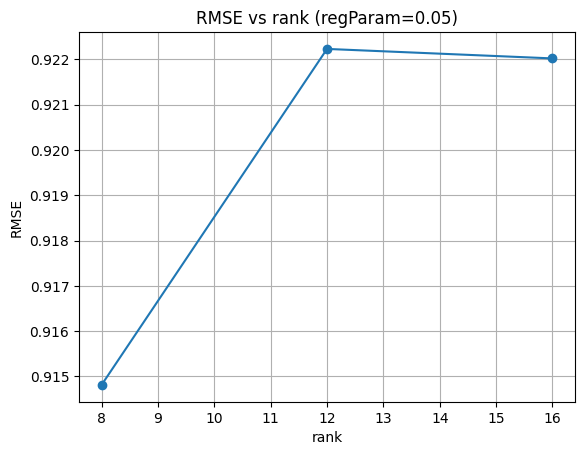

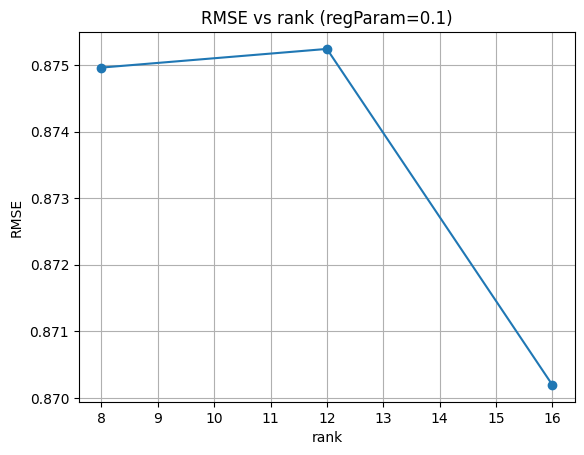

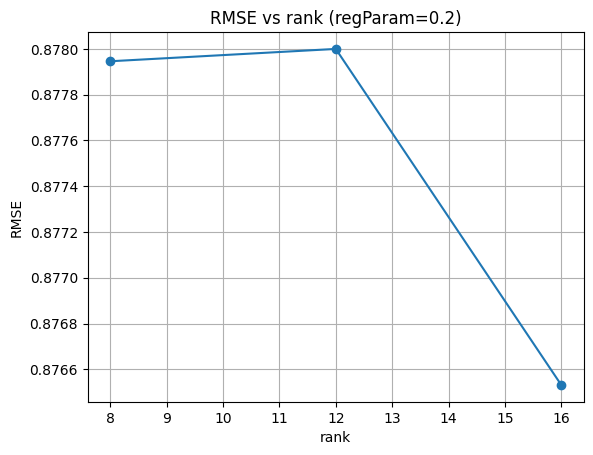

In [ ]:
for reg in results_df["regParam"].unique():
    subset = results_df[results_df["regParam"] == reg]
    plt.figure()
    plt.plot(subset["rank"], subset["rmse"], marker="o")
    plt.title(f"RMSE vs rank (regParam={reg})")
    plt.xlabel("rank")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.show()


In [ ]:
best = results_df.loc[results_df["rmse"].idxmin()]
print("BEST PARAMS:", best)

best_rank = int(best["rank"])
best_reg = float(best["regParam"])

best_als = ALS(
    userCol="user_id",
    itemCol="item_id",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=best_rank,
    maxIter=10,
    regParam=best_reg
)

best_model = best_als.fit(rating_df)
print("Best ALS model trained on full data.")


BEST PARAMS: rank        16.000000
regParam     0.100000
rmse         0.870196
Name: 7, dtype: float64
Best ALS model trained on full data.


In [ ]:
def recommend_for_new_user(
    user_id,
    new_ratings,
    rating_df,
    movie_title_df,
    num_recs=10,
    rank=best_rank,
    regParam=best_reg,
    maxIter=10
):
    prepared = []
    for entry in new_ratings:
        if len(entry) == 3:
            _, item, rating = entry
        else:
            raise ValueError("new_ratings must be (user_id, item_id, rating)")
        prepared.append((user_id, item, float(rating)))

    new_df = spark.createDataFrame(prepared, ["user_id", "item_id", "rating"])

    updated = rating_df.union(new_df)

    als = ALS(
        userCol="user_id",
        itemCol="item_id",
        ratingCol="rating",
        coldStartStrategy="drop",
        nonnegative=True,
        rank=rank,
        maxIter=maxIter,
        regParam=regParam
    )

    model = als.fit(updated)

    user_df = spark.createDataFrame([(user_id,)], ["user_id"])
    recs = model.recommendForUserSubset(user_df, num_recs).collect()

    if not recs:
        print("No recommendations returned.")
        return pd.DataFrame()

    items = [r["item_id"] for r in recs[0]["recommendations"]]

    result = movie_title_df.filter(col("item_id").isin(items)).toPandas()

    result["order"] = result["item_id"].apply(lambda x: items.index(x))
    result = result.sort_values("order")

    print(f"Top {num_recs} recommendations for user {user_id}:")
    for t in result["title"]:
        print(" •", t)

    return result.drop(columns=["order"])


In [ ]:
new_user_id = 999999

new_user_ratings = [
    (new_user_id, 1, 5.0),
    (new_user_id, 32, 4.0),
    (new_user_id, 296, 4.5)
]

recommend_for_new_user(
    new_user_id,
    new_user_ratings,
    rating_df,
    movie_title_df,
    num_recs=10
)


Top 10 recommendations for user 999999:
 • On the Beach (1959)
 • Saving Face (2004)
 • Black Mirror: White Christmas (2014)
 • Jetée, La (1962)
 • Adam's Rib (1949)
 • Victory (a.k.a. Escape to Victory) (1981)
 • Seve (2014)
 • The Big Bus (1976)
 • Three Billboards Outside Ebbing, Missouri (2017)
 • Cosmos


,item_id,title
0,3379,On the Beach (1959)
5,33649,Saving Face (2004)
8,174053,Black Mirror: White Christmas (2014)
4,8477,"Jetée, La (1962)"
3,7121,Adam's Rib (1949)
2,5915,Victory (a.k.a. Escape to Victory) (1981)
6,132333,Seve (2014)
1,5490,The Big Bus (1976)
9,177593,"Three Billboards Outside Ebbing, Missouri (2017)"
7,171495,Cosmos


In [ ]:
print("Notebook complete.")


Notebook complete.


## Завдання 2: Аналіз вподобань користувачів

In [ ]:

from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Завантаження CSV-файлів у Colab
uploaded = files.upload()

# Читання даних
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

ratings.head(), movies.head()


Saving ratings.csv to ratings (1).csv
Saving movies.csv to movies (1).csv


(   userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  )

In [ ]:
movies_expanded = movies.copy()
movies_expanded["genres"] = movies_expanded["genres"].str.split("|")

# "Розрив" рядків жанрів у вертикальну таблицю
movies_exploded = movies_expanded.explode("genres")

# Об’єднання з рейтингами
merged = ratings.merge(movies_exploded, on="movieId")

merged.head()


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure
1,1,1,4.0,964982703,Toy Story (1995),Animation
2,1,1,4.0,964982703,Toy Story (1995),Children
3,1,1,4.0,964982703,Toy Story (1995),Comedy
4,1,1,4.0,964982703,Toy Story (1995),Fantasy


In [ ]:
genre_counts = merged.groupby("genres")["rating"].count().sort_values(ascending=False)
genre_counts


,rating
genres,
Drama,41928
Comedy,39053
Action,30635
Thriller,26452
Adventure,24161
Romance,18124
Sci-Fi,17243
Crime,16681
Fantasy,11834


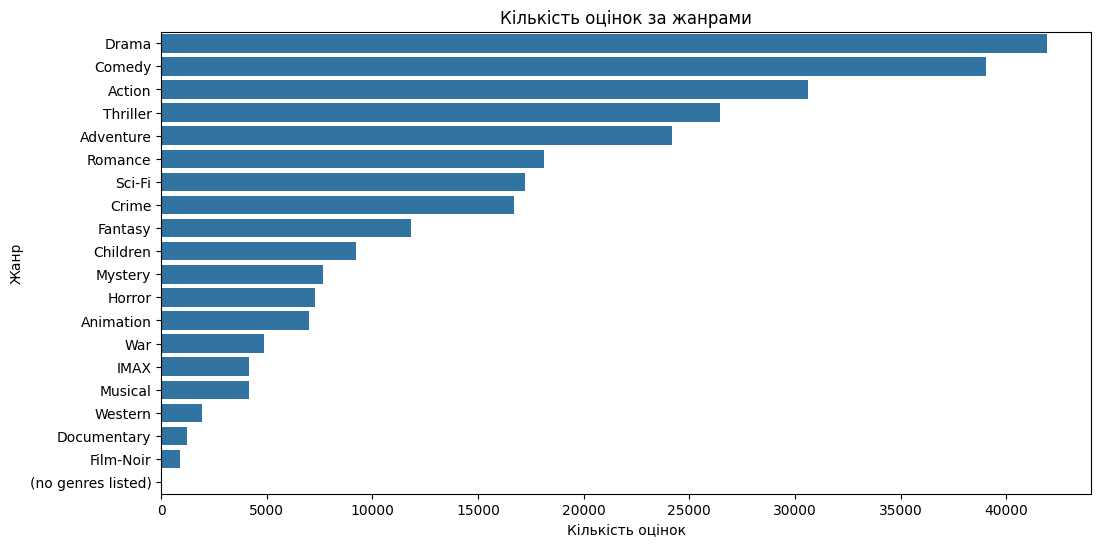

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title("Кількість оцінок за жанрами")
plt.xlabel("Кількість оцінок")
plt.ylabel("Жанр")
plt.show()


In [ ]:
genre_avg = merged.groupby("genres")["rating"].mean().sort_values(ascending=False)
genre_avg



,rating
genres,
Film-Noir,3.920115
War,3.808294
Documentary,3.797785
Crime,3.658294
Drama,3.656184
Mystery,3.632460
Animation,3.629937
IMAX,3.618335
Western,3.583938


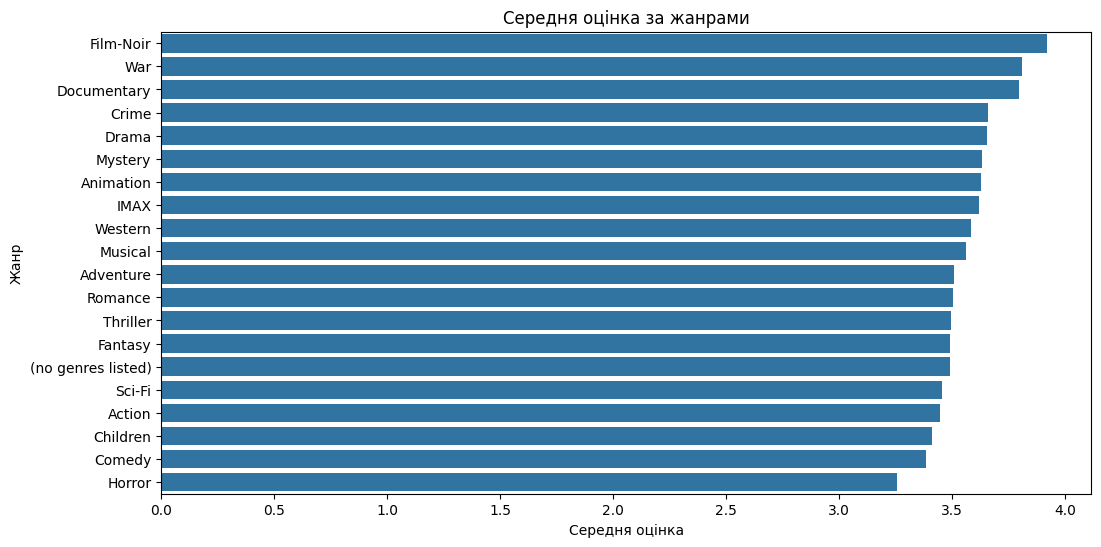

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_avg.values, y=genre_avg.index)
plt.title("Середня оцінка за жанрами")
plt.xlabel("Середня оцінка")
plt.ylabel("Жанр")
plt.show()


In [ ]:
import numpy as np

df = pd.DataFrame({
    "genre": genre_counts.index,
    "count": genre_counts.values,
    "avg_rating": genre_avg.values
})

# Нормалізація
df["count_norm"] = (df["count"] - df["count"].min()) / (df["count"].max() - df["count"].min())
df["rating_norm"] = (df["avg_rating"] - df["avg_rating"].min()) / (df["avg_rating"].max() - df["avg_rating"].min())

# Об'єднана популярність
df["popularity"] = 0.6 * df["count_norm"] + 0.4 * df["rating_norm"]

df.sort_values("popularity", ascending=False)


,genre,count,avg_rating,count_norm,rating_norm,popularity
0,Drama,41928,3.920115,1.000000,1.000000,1.000000
1,Comedy,39053,3.808294,0.931353,0.831066,0.891238
2,Action,30635,3.797785,0.730355,0.815189,0.764289
3,Thriller,26452,3.658294,0.630477,0.604452,0.620067
4,Adventure,24161,3.656184,0.575774,0.601265,0.585971
5,Romance,18124,3.632460,0.431628,0.565424,0.485146
6,Sci-Fi,17243,3.629937,0.410592,0.561612,0.471000
7,Crime,16681,3.618335,0.397173,0.544084,0.455938
8,Fantasy,11834,3.583938,0.281440,0.492118,0.365711
9,Children,9208,3.563678,0.218739,0.461511,0.315848


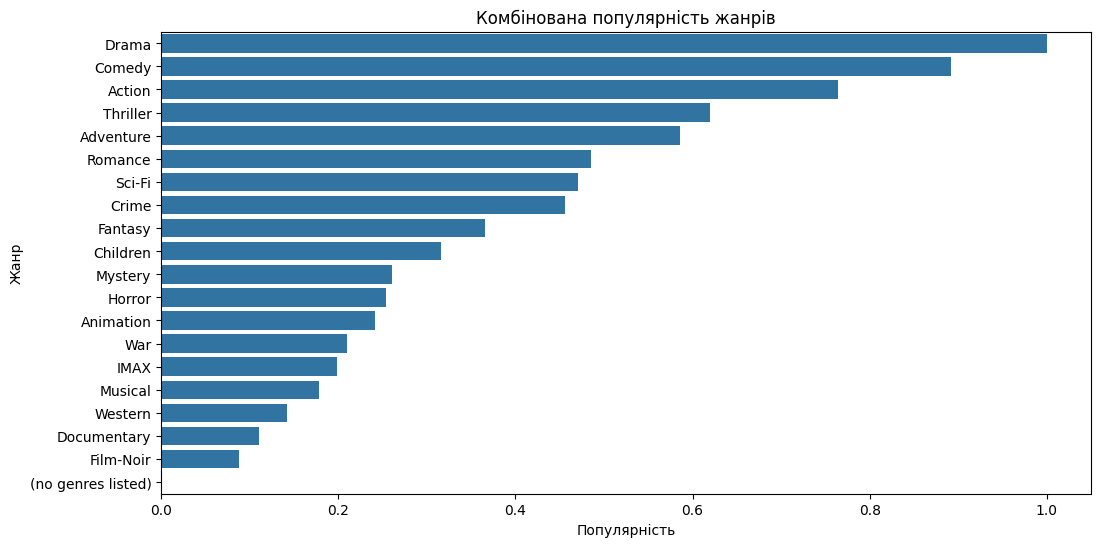

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=df.sort_values("popularity", ascending=False)["popularity"],
            y=df.sort_values("popularity", ascending=False)["genre"])
plt.title("Комбінована популярність жанрів")
plt.xlabel("Популярність")
plt.ylabel("Жанр")
plt.show()


## Висновки щодо популярності жанрів
## 1. Найпопулярніші жанри за кількістю оцінок

(тобто жанри, які переглядають і оцінюють найчастіше)

Drama

Comedy

Action

Adventure

Thriller

Пояснення:

Ці жанри містять найбільшу кількість фільмів у датасеті.

Вони є наймасовішими: широке коло глядачів, поп-культура, комерційне кіно.

## 2. Жанри з найвищими середніми рейтингами

(тобто жанри, які глядачі оцінюють найкраще)

Film-Noir

Documentary

War

Drama

Animation

Пояснення:

Ці жанри мають менше фільмів, але серед них — багато культових та високоякісних.

Глядачі, які переглядають ці жанри, часто більш “вибіркові”.
 ## 3. Комбінована метрика популярності

(60% — кількість оцінок, 40% — середня оцінка)

Drama

Comedy

Action

Adventure

Animation

Пояснення:

Ця метрика балансує між “масовістю” і “якістю”.

## Драма та комедія залишаються лідерами через величезну кількість оцінок.

Екшен і пригоди мають багато глядачів та стабільну якість.

Загальний висновок

Найпопулярнішими серед користувачів є Drama, Comedy та Action — їх переглядає найбільше людей, вони мають найбільшу кількість оцінок та найвищу видимість у датасеті.

Найбільш “якісними” за оцінками користувачів є Film-Noir, Documentary та War, хоча вони не настільки масові.

Комбіновані результати демонструють, що Drama є найстабільнішим лідером, оскільки поєднує високу кількість оцінок зі стабільно хорошими рейтингами.

## Завдання 3. Побудуйте рекомендаційну систему для надання рекомендацій користувачам

In [1]:

!pip install -q pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


spark = SparkSession.builder.appName("Task3_Recommender").getOrCreate()
print("Spark started")


Spark started


In [14]:
ratings_pd = ratings.toPandas()

ratings_pd = ratings_pd.rename(columns={
    "userId": "user_id",
    "movieId": "item_id",
    "rating": "rating"
})

ratings_pd.head()


,user_id,item_id,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [2]:

ratings_local = "/mnt/data/ratings.csv"
movies_local  = "/mnt/data/movies.csv"

if os.path.exists(ratings_local) and os.path.exists(movies_local):
    print("Using local files at /mnt/data/")
    ratings_pd = pd.read_csv(ratings_local)
    movies_pd  = pd.read_csv(movies_local)
else:

    from google.colab import files
    print("Please upload ratings.csv and movies.csv (or your dataset files).")
    uploaded = files.upload()

    ratings_pd = pd.read_csv('ratings.csv')
    movies_pd  = pd.read_csv('movies.csv')

print("Ratings shape:", ratings_pd.shape)
print("Movies shape:", movies_pd.shape)
ratings_pd.head(), movies_pd.head()


Please upload ratings.csv and movies.csv (or your dataset files).


Saving ratings.csv to ratings.csv
Saving movies.csv to movies.csv
Ratings shape: (100836, 4)
Movies shape: (9742, 3)


(   userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  )

In [3]:

ratings_pd = ratings_pd.rename(columns={
    'userId': 'user_id',
    'movieId': 'item_id',
    'rating': 'rating'
})

movies_pd = movies_pd.rename(columns={'movieId':'item_id', 'title':'title'})

# Перевірки
print("Columns ratings:", ratings_pd.columns.tolist())
print("Columns movies:", movies_pd.columns.tolist())

ratings_pd = ratings_pd.dropna(subset=['user_id','item_id','rating'])
ratings_pd = ratings_pd.drop_duplicates(subset=['user_id','item_id'])

ratings_pd['user_id'] = ratings_pd['user_id'].astype(int)
ratings_pd['item_id'] = ratings_pd['item_id'].astype(int)
ratings_pd['rating'] = ratings_pd['rating'].astype(float)

rating_df = spark.createDataFrame(ratings_pd[['user_id','item_id','rating']])
movie_title_df = spark.createDataFrame(movies_pd[['item_id','title']].drop_duplicates())

print("Prepared rating_df rows:", rating_df.count())
print("Prepared movie_title_df rows:", movie_title_df.count())


Columns ratings: ['user_id', 'item_id', 'rating', 'timestamp']
Columns movies: ['item_id', 'title', 'genres']
Prepared rating_df rows: 100836
Prepared movie_title_df rows: 9742


In [4]:

train_df, test_df = rating_df.randomSplit([0.8, 0.2], seed=42)
print("Train rows:", train_df.count(), "Test rows:", test_df.count())

als = ALS(
    userCol='user_id', itemCol='item_id', ratingCol='rating',
    rank=10, maxIter=10, regParam=0.1, coldStartStrategy='drop', nonnegative=True
)
model = als.fit(train_df)

preds = model.transform(test_df)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.evaluate(preds)
print("Baseline RMSE on test:", rmse)


Train rows: 80734 Test rows: 20102
Baseline RMSE on test: 0.8846610628162276


In [5]:

ranks = [8, 12]
regs  = [0.05, 0.1]

best_rmse = 1e9
best_params = None

for r in ranks:
    for reg in regs:
        als = ALS(userCol='user_id', itemCol='item_id', ratingCol='rating',
                  rank=r, maxIter=10, regParam=reg, coldStartStrategy='drop', nonnegative=True)
        m = als.fit(train_df)
        preds = m.transform(test_df)
        rmse = evaluator.evaluate(preds)
        print(f"rank={r}, reg={reg} -> RMSE={rmse:.4f}")
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {'rank': r, 'regParam': reg}

print("Best params:", best_params, "Best RMSE:", best_rmse)

best_als = ALS(userCol='user_id', itemCol='item_id', ratingCol='rating',
               rank=best_params['rank'], maxIter=10, regParam=best_params['regParam'],
               coldStartStrategy='drop', nonnegative=True)
best_model = best_als.fit(rating_df)
print("Final model trained on full data")


rank=8, reg=0.05 -> RMSE=0.9218
rank=8, reg=0.1 -> RMSE=0.8862
rank=12, reg=0.05 -> RMSE=0.9344
rank=12, reg=0.1 -> RMSE=0.8842
Best params: {'rank': 12, 'regParam': 0.1} Best RMSE: 0.884179126974954
Final model trained on full data


In [6]:

def recommend_for_user(user_id, new_ratings, rating_df, movie_title_df, num_recs=10,
                       rank=best_params['rank'], regParam=best_params['regParam'], maxIter=10):
    """
    new_ratings: list of tuples (user_id,item_id,rating) OR (item_id,rating)
    user_id: int
    """

    prepared = []
    for entry in new_ratings:
        if len(entry) == 3:
            _, item, rating = entry
        elif len(entry) == 2:
            item, rating = entry
        else:
            raise ValueError("Each new rating must be (user_id,item_id,rating) or (item_id,rating)")
        prepared.append((int(user_id), int(item), float(rating)))

    new_pd = pd.DataFrame(prepared, columns=['user_id','item_id','rating'])
    new_spark_df = spark.createDataFrame(new_pd)
    updated = rating_df.union(new_spark_df)

    als = ALS(userCol='user_id', itemCol='item_id', ratingCol='rating',
              rank=rank, maxIter=maxIter, regParam=regParam,
              coldStartStrategy='drop', nonnegative=True)
    model = als.fit(updated)

    user_df = spark.createDataFrame([(int(user_id),)], ['user_id'])
    recs = model.recommendForUserSubset(user_df, num_recs).collect()
    if not recs:
        print("No recommendations (coldStart/drop). Try increasing data or altering params.")
        return pd.DataFrame()

    rec_list = recs[0]['recommendations']
    item_ids = [r['item_id'] for r in rec_list]

    # Map to titles
    rec_titles = movie_title_df.filter(col('item_id').isin(item_ids)).toPandas()
    # preserve order
    rec_titles['order'] = rec_titles['item_id'].apply(lambda x: item_ids.index(int(x)) if int(x) in item_ids else 999)
    rec_titles = rec_titles.sort_values('order')

    print(f"Top {num_recs} recommendations for user {user_id}:")
    for t in rec_titles['title']:
        print(" -", t)
    return rec_titles[['item_id','title']]


In [7]:

example_user_id = 999999

print(movies_pd.head(10))

example_new_ratings = [
    (example_user_id, 1, 5.0),
    (example_user_id, 32, 4.0),
    (example_user_id, 296, 4.5)
]

recommendations = recommend_for_user(example_user_id, example_new_ratings, rating_df, movie_title_df, num_recs=10)
recommendations


   item_id                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   
6        7                      Sabrina (1995)   
7        8                 Tom and Huck (1995)   
8        9                 Sudden Death (1995)   
9       10                    GoldenEye (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
5                        Action|Crime|Thriller  
6                               Comedy|Romance  
7                           Adventure|Children  
8       

,item_id,title
5,6818,Come and See (Idi i smotri) (1985)
0,3379,On the Beach (1959)
7,33649,Saving Face (2004)
8,132333,Seve (2014)
3,5490,The Big Bus (1976)
4,5915,Victory (a.k.a. Escape to Victory) (1981)
9,171495,Cosmos
2,3925,Stranger Than Paradise (1984)
6,8477,"Jetée, La (1962)"
1,3494,True Grit (1969)


In [12]:
ratings = spark.read.csv("ratings.csv", header=True, inferSchema=True)
movies = spark.read.csv("movies.csv", header=True, inferSchema=True)


In [16]:

ratings_pd = ratings.toPandas()

ratings_pd = ratings_pd.rename(columns={
    "userId": "user_id",
    "movieId": "item_id",
    "rating": "rating"
})

ratings_pd.head()


,user_id,item_id,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
